In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from dotenv import load_dotenv
import requests

In [5]:
load_dotenv()

SLACK_WEBHOOK_URL = os.getenv("SLACK_WEBHOOK_URL")
DATA_PATH = os.path.join("..", "data", "analyzed_ai_market_data.csv")
FORECAST_DAYS = 14

In [6]:
def send_slack_alert(message: str):
    """Send a message to Slack via webhook"""
    if not SLACK_WEBHOOK_URL:
        print("⚠️ Slack webhook not set, skipping alert.")
        return
    try:
        r = requests.post(SLACK_WEBHOOK_URL, json={"text": message})
        if r.status_code == 200:
            print("📩 Slack alert sent.")
        else:
            print(f"⚠️ Slack alert failed ({r.status_code})")
    except Exception as e:
        print(f"❌ Slack alert error: {e}")

In [7]:
def load_data():
    """Load sentiment data from pre-existing CSV file"""
    if not os.path.exists(DATA_PATH):
        raise FileNotFoundError(f"❌ File not found: {DATA_PATH}")

    df = pd.read_csv(DATA_PATH)

    if "timestamp" not in df.columns or "score" not in df.columns:
        raise ValueError("❌ Missing required columns: 'timestamp' and 'score'")

    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    df["score"] = pd.to_numeric(df["score"], errors="coerce")
    df = df.dropna(subset=["timestamp", "score"])

    # Use only recent 90 days
    df = df[df["timestamp"] >= (df["timestamp"].max() - pd.Timedelta(days=90))]

    daily = df.groupby(df["timestamp"].dt.date)["score"].mean().reset_index()
    daily.columns = ["ds", "y"]
    daily["ds"] = pd.to_datetime(daily["ds"])
    daily = daily.sort_values("ds").reset_index(drop=True)

    print(f"✅ Loaded {len(daily)} daily sentiment records.")
    return daily

In [8]:
def run_prophet_forecast(df):
    """Run Prophet forecast and generate forecast plot"""
    model = Prophet(
        daily_seasonality=True,
        weekly_seasonality=True,
        yearly_seasonality=False,
        changepoint_prior_scale=0.5  # more sensitive to small changes
    )
    model.fit(df)

    future = model.make_future_dataframe(periods=FORECAST_DAYS, freq="D")
    forecast = model.predict(future)

    # ------------------ Plot ------------------
    fig, ax = plt.subplots(figsize=(10, 5))
    model.plot(forecast, ax=ax)

    ax.set_title("AI Market Sentiment Forecast", fontsize=14)
    ax.set_xlabel("Date")
    ax.set_ylabel("Sentiment Score")
    plt.xticks(rotation=45)
    plt.tight_layout()

    os.makedirs("../plots", exist_ok=True)
    plot_path = "../plots/prophet_sentiment_forecast.png"
    fig.savefig(plot_path)
    plt.show()  # 👈 Display live plot window
    print(f"🖼️ Forecast plot saved to {plot_path}")

    # Check and send alerts
    check_alerts(forecast)

    return forecast

In [9]:
def check_alerts(forecast):
    """Send Slack alerts for all sentiment trends"""
    last = forecast.tail(FORECAST_DAYS)

    # Detect strong negative and positive trends
    neg = last[last["yhat"] < -0.2]
    pos_jump = last[last["yhat"].diff() > 0.4]

    if not neg.empty:
        date = neg.iloc[0]["ds"].strftime("%Y-%m-%d")
        msg = f"⚠️ Negative sentiment predicted around {date} (yhat={neg.iloc[0]['yhat']:.2f})"
        print(msg)
        send_slack_alert(msg)

    if not pos_jump.empty:
        date = pos_jump.iloc[0]["ds"].strftime("%Y-%m-%d")
        msg = f"🚀 Sentiment surge expected around {date} (+{pos_jump.iloc[0]['yhat'] - pos_jump.iloc[0]['yhat_lower']:.2f})"
        print(msg)
        send_slack_alert(msg)

    # --- Always send daily trend alert ---
    latest = forecast.tail(2)
    if len(latest) >= 2:
        change = latest["yhat"].iloc[-1] - latest["yhat"].iloc[-2]

        if change > 0:
            send_slack_alert(f"📈 Sentiment slightly improving (+{change:.2f}). AI market showing mild optimism.")
        elif change < 0:
            send_slack_alert(f"📉 Sentiment slightly declining ({change:.2f}). Monitor AI trends closely.")
        else:
            send_slack_alert(f"😐 Sentiment stable (Δ={change:.2f}). No major fluctuations today.")

    avg_sentiment = forecast["yhat"].mean()
    send_slack_alert(f"🧭 Forecast complete. Average sentiment level: {avg_sentiment:.2f}")

🚀 Running Prophet Forecast on Local CSV
✅ Loaded 27 daily sentiment records.


20:09:48 - cmdstanpy - INFO - Chain [1] start processing
20:09:49 - cmdstanpy - INFO - Chain [1] done processing


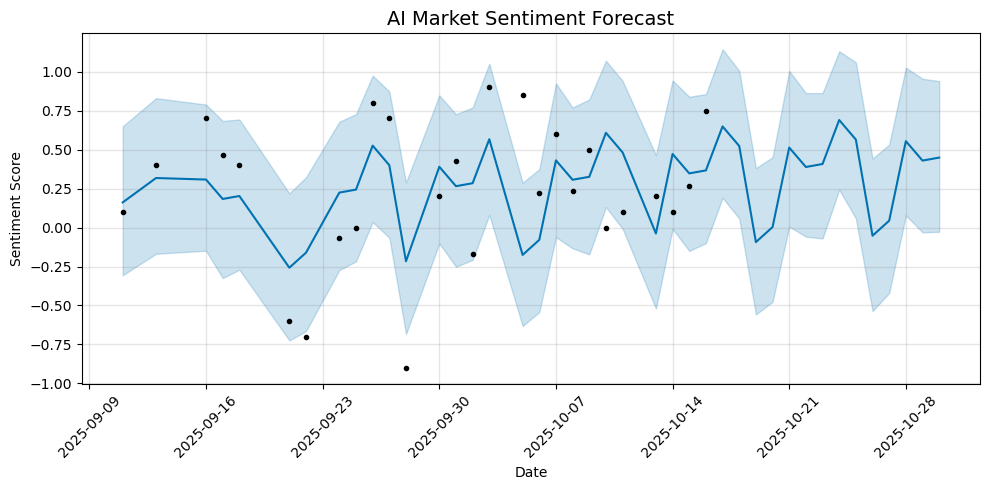

🖼️ Forecast plot saved to ../plots/prophet_sentiment_forecast.png
🚀 Sentiment surge expected around 2025-10-21 (+0.51)
📩 Slack alert sent.
📩 Slack alert sent.
📩 Slack alert sent.
✅ Forecasting and alerting completed successfully.


In [10]:
if __name__ == "__main__":
    print("🚀 Running Prophet Forecast on Local CSV")
    df = load_data()
    forecast = run_prophet_forecast(df)
    print("✅ Forecasting and alerting completed successfully.")